# **CS 181 HW5**
---

## Problem 2

#### Initialize data and parameters

Consider a specific example of when we have $K = 3$ component Gamma distributions. Let's initialize the initial parameter values for $\theta$ and $\beta_k$ as follows:
$$
\begin{align*}
  \theta_k &=  1/K, \\
  \beta_k & = k/K.
\end{align*}
$$

Note that we usually initialize $\theta$ and $\beta_k$ randomly. However, by fixing the initial $\theta$ and $\beta_k$, EM becomes deterministic which makes debugging (and grading) easier.



In [2]:
import torch
import torch.distributions as ds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

x = torch.load('data.pt')

In [3]:
# # uncomment to use numpy (optional)
# import numpy as np
# from scipy.stats import gamma
# x = x.numpy()
# theta = theta.numpy()
# betas = betas.numpy()

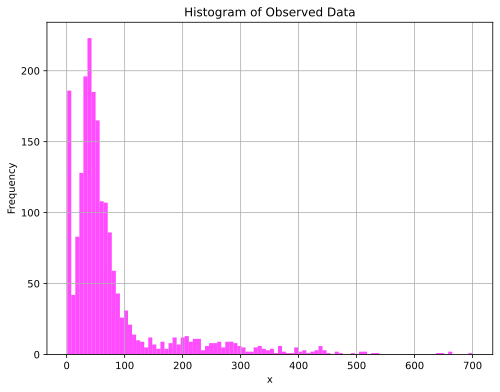

In [4]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.hist(x.numpy(), bins=100, color='magenta', alpha=0.7)
plt.title('Histogram of Observed Data')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### **Todo:** implement the E-step

In [5]:
def e_step(theta, betas):
    # vectorize the gammas 
    dist = ds.Gamma(alpha, betas)

    # add the thetas bc log 
    log_q = dist.log_prob(x) + theta.log()

    # normalize q
    log_q = log_q - log_q.logsumexp(dim=1, keepdim = True)

    return log_q.exp()

#### **Todo:** implement the M-step

In [6]:
def m_step(q):
    # Update theta (according to update equation found in pt 1)
    theta_hat = q.sum(dim=0) / len(x)
    
    # Update beta_hats 
    beta_hats = alpha * q.sum(dim=0) / (q * x).sum(dim=0)
    
    return theta_hat, beta_hats

#### **Todo:** implement log likelihood

In [7]:
def log_px(x, theta, betas):
    z = ds.Categorical(theta)
    new = ds.Gamma(alpha, betas)
    gmm = ds.MixtureSameFamily(z, new)
    return gmm.log_prob(x)

def log_likelihood(theta, betas):
    return log_px(x, theta, betas).sum()

#### **Todo:** implement EM algorithm

In [8]:
def run_em(theta, betas, iterations=1000):    
    for i in range(iterations):
        # Perform E-step
        q = e_step(theta, betas)

        # Perform M-step
        theta, betas = m_step(q)
    return theta, betas

#### Plot 

In [9]:
def make_overlay_plot(theta, betas):
    x_test = torch.linspace(0.01, x.max(), 1000)
    prob = log_px(x_test.unsqueeze(-1), theta, betas).exp()
    # prob = np.exp(log_px(x_test.unsqueeze(-1), theta, betas))  # use this line for numpy
    ll = log_likelihood(theta, betas)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    fig.subplots_adjust(top=0.7)
    fig.suptitle(f'theta = {theta}\nbeta = {betas}\nlog likelihood = {ll:.3e}')
    
    ax.hist(x.T, bins=100, color='tomato', alpha=0.5, density=True, label='Dataset')
    ax.plot(x_test, prob, color='royalblue', label='Gamma mixture')
    
    ax.set_title(f'Dataset and Gamma mixture (K={len(theta)})')
    ax.set_xlabel('Recovery time (hours)')
    ax.set_ylabel('Density')
    ax.legend()

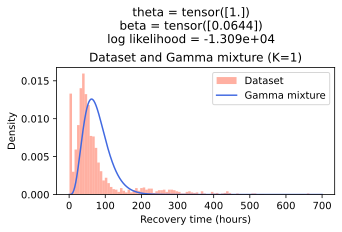

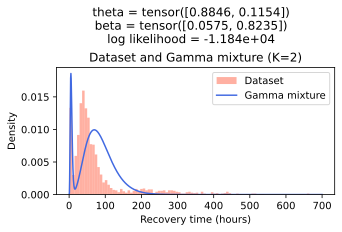

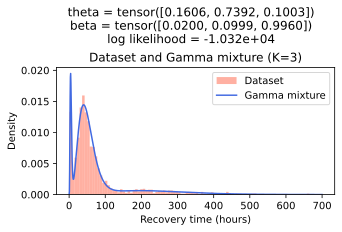

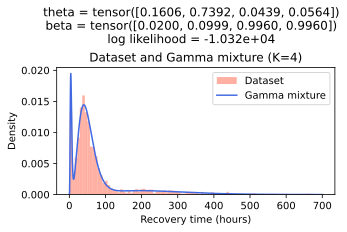

In [10]:
alpha = 5.0
for K in range(1,5):
    theta0 = torch.ones(K) / K
    betas0 = (torch.arange(K) + 1) / K
    # theta0 = np.ones(K) / K               # use this for numpy
    # betas0 = (np.arange(K) + 1) / K
    
    theta, betas = run_em(theta0, betas0)
    
    make_overlay_plot(theta, betas)
    plt.savefig(f'p2_3_{K}mixtures.pdf', bbox_inches='tight')

---
## Problem 3

#### Initialize data:

In [11]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)  # download MNIST
N = 6000 

x = mnist_trainset.data[:N]  # select N datapoints
x = x.flatten(1)             # flatten the images
x = x.float()                # convert pixels from uint8 to float
x = x.numpy()              # uncomment to use numpy (optional)

#### **Todo:** implement PCA

*Hint: see `.linalg.svd()`*

In [12]:
def pca(x, n_comps=500):
    # center data
    x_c = x - np.mean(x,axis=0)

    # perform svd and normalize by dividing by sqrt x.shape[0]
    _, s, Vt = np.linalg.svd(x_c / np.sqrt(x.shape[0]), full_matrices = False)
    eigvals = s**2

    # get most principal components 
    top_eigvals = eigvals[:n_comps]
    top_pcomps = Vt[:n_comps, :]
    return top_eigvals, top_pcomps

#### **Todo:** calculate cumulative fraction of variance

*Hint: see `.cumsum()`*

In [13]:
def calc_cfvs(eigvals):
    cum_frac_vars = np.cumsum(eigvals / np.sum(eigvals))
    return cum_frac_vars

#### **Todo:** calculate mean squared L2 norm reconstruction loss

In [14]:
def calc_errs(x, pcomps):
    # center data
    x_c = x - np.mean(x,axis=0)

    err_mean = np.mean(np.linalg.norm(x_c, axis=1)**2)
    # Projecting data onto the first 10 principal components and then back, compute the error between original data and reconstructed data
    err_pcomp = np.mean(np.linalg.norm(x - (np.dot(np.dot(x_c, pcomps[:10].T), pcomps[:10]) + np.mean(x, axis=0)), axis=1) ** 2)
    return err_mean, err_pcomp

#### Plot and print errors:

In [15]:
def plot_pic(pic, ax, title=''):
    x = pic.reshape(28, 28)
    ax.imshow(x, cmap='binary')
    ax.set_title(title)
    ax.axis('off')

def make_plots(eigvals, cfvs, x_mean, pcomps):
    # plot eigenvals and cfvs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(eigvals, color='tomato')
    ax1.set_title('Eigenvalues')
    ax2.plot(cfvs, color='tomato')
    ax2.set_title('CFVs')
    fig.savefig('p3_cfvs.pdf')

    # plot mean
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_pic(x_mean, ax, title='Mean')
    fig.savefig('p3_mean.pdf')

    # plot top 10 pcomps
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        plot_pic(pcomps[i], axes.flat[i], title=f'PC index {i}')
    fig.savefig('p3_pcomps.pdf')

Reconstruction error (using mean): 3.436024e+06
Reconstruction error (using mean and top 10 pcomps): 1.731315e+06


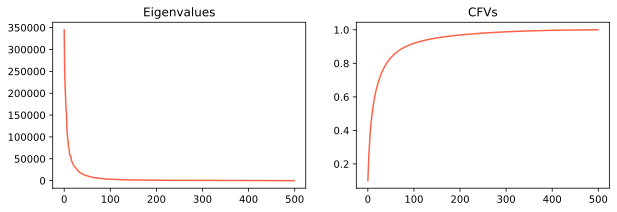

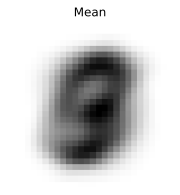

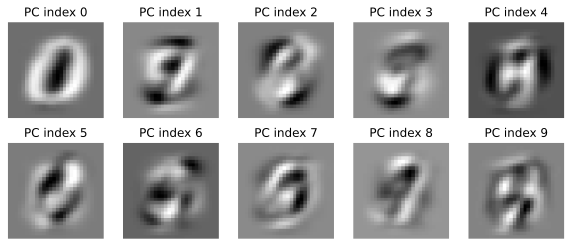

In [16]:
# do PCA
eigvals, pcomps = pca(x)

# calculate CFVs
fcvs = calc_cfvs(eigvals)

# print errors
err_mean, err_pcomp = calc_errs(x, pcomps)
print(f'Reconstruction error (using mean): {err_mean:3e}')
print(f'Reconstruction error (using mean and top 10 pcomps): {err_pcomp:3e}')

# make plots
make_plots(eigvals, fcvs, x.mean(0), pcomps)
